# ESBL-producing E. coli Dynamic ABM in Tanzanian NICUs (version 1.0)
Luyuan Zhao 
2025-05-19 


1. Loading necessary packages

In [1]:
using Random               # random number generation
using StatsBase            # sample without replacement
using Plots;
gr();                      # plotting backend

2. State & agent enumerations

In [2]:
@enum BabyState S C_S C_R I_S I_R REC         
# To track the infection or AMR status of each neonate
# S=Susceptible, C_S=Colonized Susceptible, C_R=Colonized Resistant, 
# I_S=Infected Susceptible, I_R=Infected Resistant, REC=Recovered

@enum CarrierState CLEAN CONTAM               
# Describe whether a health-care worker (HCW) or device is contaminated

@enum AgentType BABY HCW DEVICE               
# Let one common struct represent babies, HCWs and devices while still knowing “what kind of thing am I?”

3. Agent & Environment settings

In [3]:
# Agent - Stores identification, type, health status, contamination status and timestamps for epidemiological events.
mutable struct Agent
    id::Int
    atype::AgentType
    bstate::BabyState      # only meaningful for babies
    cstate::CarrierState   # only meaningful for HCW / device
    variant::Symbol        # :S or :R
    tick::Int              # days since entering current state
    abx_left::Int          # antibiotic days remaining
end

In [4]:
mutable struct Environment
    babies::Vector{Agent}
    hcws::Vector{Agent}
    devices::Vector{Agent}

    # All βeta parameters are the probabilities of transmission between agents.
    β_hb::Float64          # HCW -> Baby
    β_bh::Float64          # Baby -> HCW
    β_db::Float64          # Device -> Baby
    β_bd::Float64          # Baby -> Device
    β_dh::Float64          # Device -> HCW
    β_hd::Float64          # HCW -> Device  

    # The number of contacts among babies, HCWs and devices.
    contacts_hb::Int       # HCW <-> Baby contacts per day
    contacts_db::Int       # Device <-> Baby contacts
    contacts_dh::Int       # HCW <-> Device contacts  

    # The probability of all bacteria changes in the environment.
    p_progress::Float64    # colonised -> infection
    p_recovery_S::Float64  # I_S recovery
    p_recovery_R::Float64  # I_R recovery
    abx_course::Int        # length of empiric therapy (days)
    p_selection::Float64   # probability C_S -> C_R under ABX

    # The probability of decontamination of HCWs and devices.
    p_decontam_hcw::Float64
    p_decontam_dev::Float64
    
    # Time steps, all stats needed 
    # Counts the total number of antibiotic treatment days given to babies over the whole simulation
    # and the number of selection events (i.e. when a baby is given antibiotics).
    tick::Int
    stats::Dict{BabyState,Vector{Int}}
    total_abx_days::Int
    selection_events::Int
end

4.  Initialization

In [ ]:
# Initial Status (default values)
# There are 10 babies, 3 HCWs and 5 devices in the environment.
function init_env(; N_babies=10, N_hcws=3, N_devices=5,
    β_hb=0.04, β_bh=0.12, β_db=0.08, β_bd=0.2,
    β_dh=0.05, β_hd=0.05,
    contacts_hb=67, contacts_db=20, contacts_dh=30,
    p_progress=0.03, p_recovery_S=0.20, p_recovery_R=0.12,
    abx_course=5, p_selection=0.25,
    p_decontam_hcw=0.40, p_decontam_dev=0.30,
    rng=Random.GLOBAL_RNG)

    # We introduce 1 initial contamination or colonisation event in only one baby to avoid a sterile system.
    # Create babies
    babies = Agent[]
    for i in 1:N_babies
        bstate = (i == 1) ? C_S : S          # first baby starts colonized
        baby = Agent(i, BABY, bstate, CLEAN, :S, 0, 0)
        push!(babies, baby)
    end

    # Create HCWs
    hcws = Agent[]
    for i in 1:N_hcws
        hcw = Agent(i, HCW, S, CLEAN, :S, 0, 0)
        push!(hcws, hcw)
    end

    # Create devices
    devices = Agent[]
    for i in 1:N_devices
        device = Agent(i, DEVICE, S, CLEAN, :S, 0, 0)
        push!(devices, device)
    end

    # stats dict initialisation
    stats = Dict(s => Int[] for s in instances(BabyState))
    

    return Environment(babies, hcws, devices,
        β_hb, β_bh, β_db, β_bd, β_dh, β_hd,
        contacts_hb, contacts_db, contacts_dh,
        p_progress, p_recovery_S, p_recovery_R,
        abx_course, p_selection,
        p_decontam_hcw, p_decontam_dev,
        0, stats, 0, 0)
end

init_env (generic function with 1 method)

5. Helper: sample without replacement

In [6]:
sample_norpl(rng, v::Vector, n::Int) = StatsBase.sample(rng, v, min(n, length(v)), replace=false)

sample_norpl (generic function with 1 method)

6. Record stats

In [7]:
# To record the number of agents in each state and add it to the stats dictionary.
function record_stats!(env::Environment)
    # Count the number of babies in each state
    # and add it to the stats dictionary.
    counts = countmap(b.bstate for b in env.babies)
    # Record all possible states (6) traversed
    for s in instances(BabyState)
        # Add the number of people in this status today to the corresponding time series.
        push!(env.stats[s], get(counts, s, 0))
    end
end

record_stats! (generic function with 1 method)

7. Daily dynamics

The function daily_step!() simulates the daily dynamics of the environment.

In [8]:
function daily_step!(env::Environment, rng::AbstractRNG)

    #HCW <=> Baby contacts (bidirectional) ----------
    for h in env.hcws
        for b in sample_norpl(rng, env.babies, env.contacts_hb)

            # HCW -> Baby: A contaminated HCW touches a susceptible baby
            # with transmission probability β_hb, baby becomes colonized with susceptible strain
            if h.cstate == CONTAM && b.bstate == S && rand(rng) < env.β_hb
                # Trigger an event with probability β_hb
                b.bstate = C_S
                b.variant = :S
                b.tick = 0
            end

            # Baby -> HCW: A colonized/infected baby contaminates a clean HCW
            # with probability β_bh during contact
            if b.bstate in (C_S, C_R, I_S, I_R) && h.cstate == CLEAN && rand(rng) < env.β_bh
                h.cstate = CONTAM
            end
        end
    end

    # Device ↔ Baby contacts
    for d in env.devices
        for b in sample_norpl(rng, env.babies, env.contacts_db)

            # Device -> Baby: A contaminated device touches a susceptible baby
            # with transmission probability β_db
            if d.cstate == CONTAM && b.bstate == S && rand(rng) < env.β_db
                b.bstate = C_S
                b.variant = :S
                b.tick = 0
            end

            # Baby -> Device: A colonized/infected baby contaminates a clean device
            # with probability β_bd during contact
            if b.bstate in (C_S, C_R, I_S, I_R) && d.cstate == CLEAN && rand(rng) < env.β_bd
                d.cstate = CONTAM
            end
        end
    end

    # HCW <=> Device contacts (NEW bidirectional) ---
    for h in env.hcws
        for d in sample_norpl(rng, env.devices, env.contacts_dh)
            # Device → HCW: A contaminated device contaminates a clean HCW
            if d.cstate == CONTAM && h.cstate == CLEAN && rand(rng) < env.β_dh
                h.cstate = CONTAM
            end

            # HCW -> Device: A contaminated HCW contaminates a clean device 
            if h.cstate == CONTAM && d.cstate == CLEAN && rand(rng) < env.β_hd
                d.cstate = CONTAM
            end
        end
    end

    # HCW / Device decontamination 
    # Each contaminated HCW has a chance to become clean (hand hygiene)
    for h in env.hcws
        h.cstate = (h.cstate == CONTAM && rand(rng) < env.p_decontam_hcw) ? CLEAN : h.cstate
    end

    # Each contaminated device has a chance to be disinfected
    for d in env.devices
        d.cstate = (d.cstate == CONTAM && rand(rng) < env.p_decontam_dev) ? CLEAN : d.cstate
    end

    # Within-baby events 
    for b in env.babies

        # Antibiotic usage: if currently receiving antibiotics

        #If you are currently undergoing treatment, reduce the remaining treatment course 
        #by one day and increase the total treatment days by 1
        if b.abx_left > 0
            b.abx_left -= 1
            env.total_abx_days += 1

            # Selection pressure: C_S -> C_R during antibiotic treatment
            if b.bstate == C_S && rand(rng) < env.p_selection
                b.bstate = C_R
                b.variant = :R
                b.tick = 0
                env.selection_events += 1
            end
        end

        # Disease progression: colonization becomes infection
        # Only colonized infants are likely to further develop infections
        if b.bstate in (C_S, C_R) && rand(rng) < env.p_progress
            b.bstate = (b.bstate == C_S) ? I_S : I_R
            b.abx_left = env.abx_course
            # Reset the duration counter of the baby in the current state
            b.tick = 0
        end

        # Recovery from infection: I_S or I_R → REC
        if (b.bstate == I_S && rand(rng) < env.p_recovery_S) ||
           (b.bstate == I_R && rand(rng) < env.p_recovery_R)
            b.bstate = REC
            b.abx_left = 0
            # Reset the duration counter of the baby in the current state
            b.tick = 0
        end

        b.tick += 1
    end

    env.tick += 1
end


daily_step! (generic function with 1 method)

8. Simulation Loop

In [9]:
# Simulation controller
# Runs the full simulation for a given number of days (90 days here by default)
# and record the number of babies in each state (S, C_S, C_R, I_S, I_R, REC)
function run!(env::Environment; days=90, rng=Random.GLOBAL_RNG)
    record_stats!(env)
    for _ in 1:days
        daily_step!(env, rng)
        record_stats!(env)
    end
end

run! (generic function with 1 method)

9. Results and Visualisations

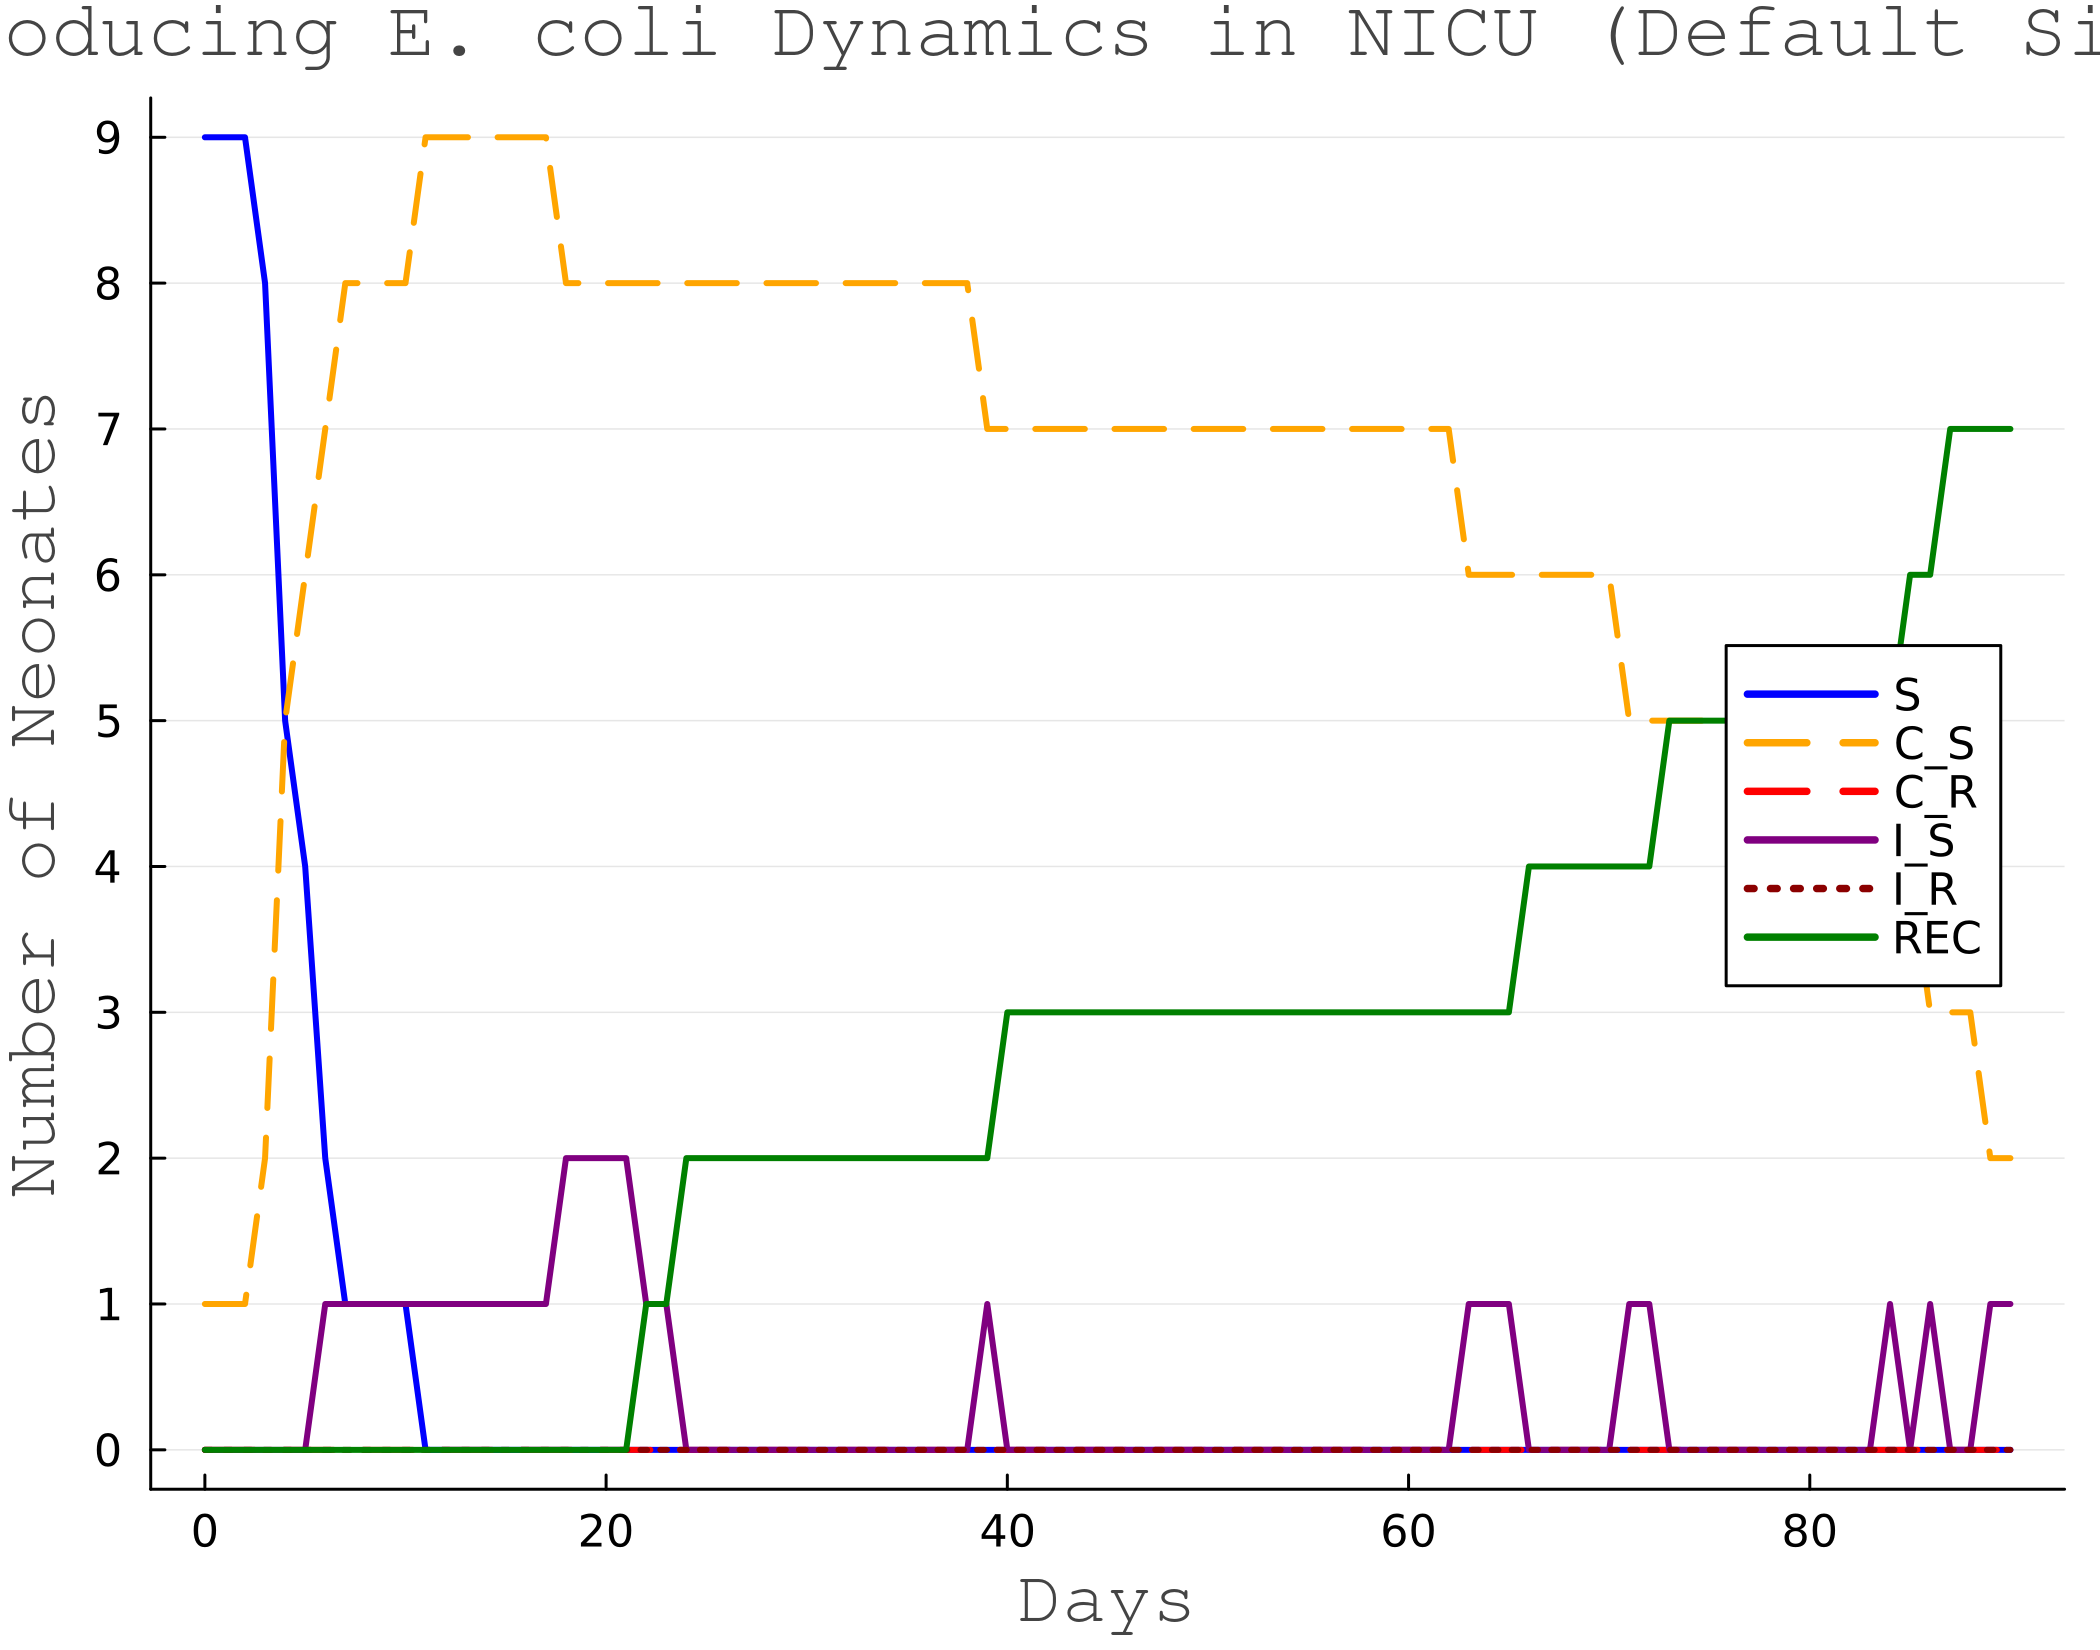

Starting E. coli ABM (with initial contamination)...

Peak infections (I_S + I_R): 2
Total antibiotic days: 18
C_S → C_R selection events:  0
Avg total ABX treatment days per baby: 1.8


In [17]:
function main()
    println("Starting E. coli ABM (with initial contamination)...")

    env = init_env()                  
    run!(env, days=90)                

    # Compute total infections per day
    infections = [env.stats[I_S][t] + env.stats[I_R][t] for t in 1:length(env.stats[I_S])]
    peak_inf = maximum(infections)

    # Plotting
    days = 0:(length(env.stats[S])-1)

    # 自定义配色和线型
    state_styles = Dict(
        S => (:blue, :solid),
        C_S => (:orange, :dash),
        C_R => (:red, :dash),
        I_S => (:purple, :solid),
        I_R => (:darkred, :dot),
        REC => (:green, :solid)
    )

    plt = plot(
        title="ESBL-producing E. coli Dynamics in NICU (Default Simulation)",
        xlabel="Days",
        ylabel="Number of Neonates",
        legend=:right,
        dpi=300,
        size=(700, 550),
        xtickfont=font(10),
        ytickfont=font(10),
        guidefont=font(13, "Arial"),
        titlefont=font(14, "Arial"),
        legendfontsize=10,
        grid=:y
    )

    # 添加每条状态曲线
    for s in instances(BabyState)
        color, linetype = state_styles[s]
        plot!(plt, days, env.stats[s], label=string(s), color=color, linestyle=linetype, linewidth=2)
    end

    # Y轴使用整数刻度
    ymax = maximum([maximum(env.stats[s]) for s in instances(BabyState)])
    plot!(plt, yticks=0:1:ymax)

    display(plt)

    # Summary output
    println("\nPeak infections (I_S + I_R): ", peak_inf)
    println("Total antibiotic days: ", env.total_abx_days)
    println("C_S → C_R selection events:  ", env.selection_events)

    # Average ABX days per baby
    # (total ABX days / number of babies)
    N_babies = length(env.babies)
    avg_abx_days_per_baby = round(env.total_abx_days / N_babies, digits=2)
    println("Avg total ABX treatment days per baby: ", avg_abx_days_per_baby)
end

main()

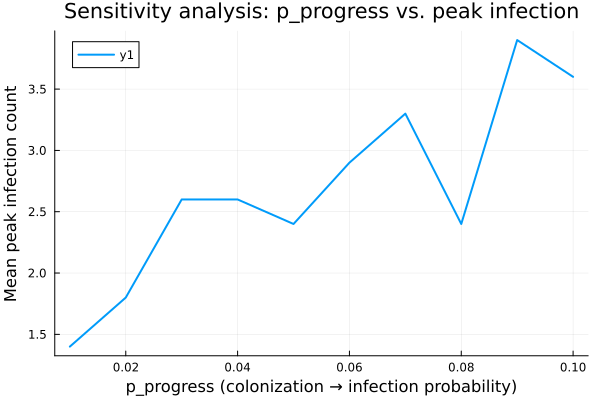

In [63]:
using Plots

function sweep_p_progress(p_range=0.01:0.01:0.1; N_repeats=10)
    mean_peaks = Float64[]

    for p in p_range
        peaks = Float64[]
        for i in 1:N_repeats
            env = init_env(p_progress=p)
            run!(env, days=90)
            infections = [env.stats[I_S][t] + env.stats[I_R][t] for t in 1:91]
            push!(peaks, maximum(infections))
        end
        push!(mean_peaks, mean(peaks))  # 每个p值下重复多次取平均峰值
    end

    plot(p_range, mean_peaks,
        xlabel="p_progress (colonization → infection probability)",
        ylabel="Mean peak infection count",
        title="Sensitivity analysis: p_progress vs. peak infection",
        lw=2)
end

sweep_p_progress()


In [ ]:
using Statistics, Plots

function replicate_simulations(N=50, days=90)
    all_curves = []

    for i in 1:N
        env = init_env()
        run!(env, days=days)
        inf = [env.stats[I_S][t] + env.stats[I_R][t] for t in 1:(days+1)]
        push!(all_curves, inf)
    end

    mat = reduce(hcat, all_curves)  # 每一列是一次模拟
    mean_inf = mean(mat, dims=2)[:]
    sd_inf = std(mat, dims=2)[:]

    plot(0:days, mean_inf,
        ribbon=sd_inf,
        xlabel="Days", ylabel="Infected neonates",
        title="Mean ± SD of daily infections over $N runs",
        lw=2, legend=false)
end

replicate_simulations(50)


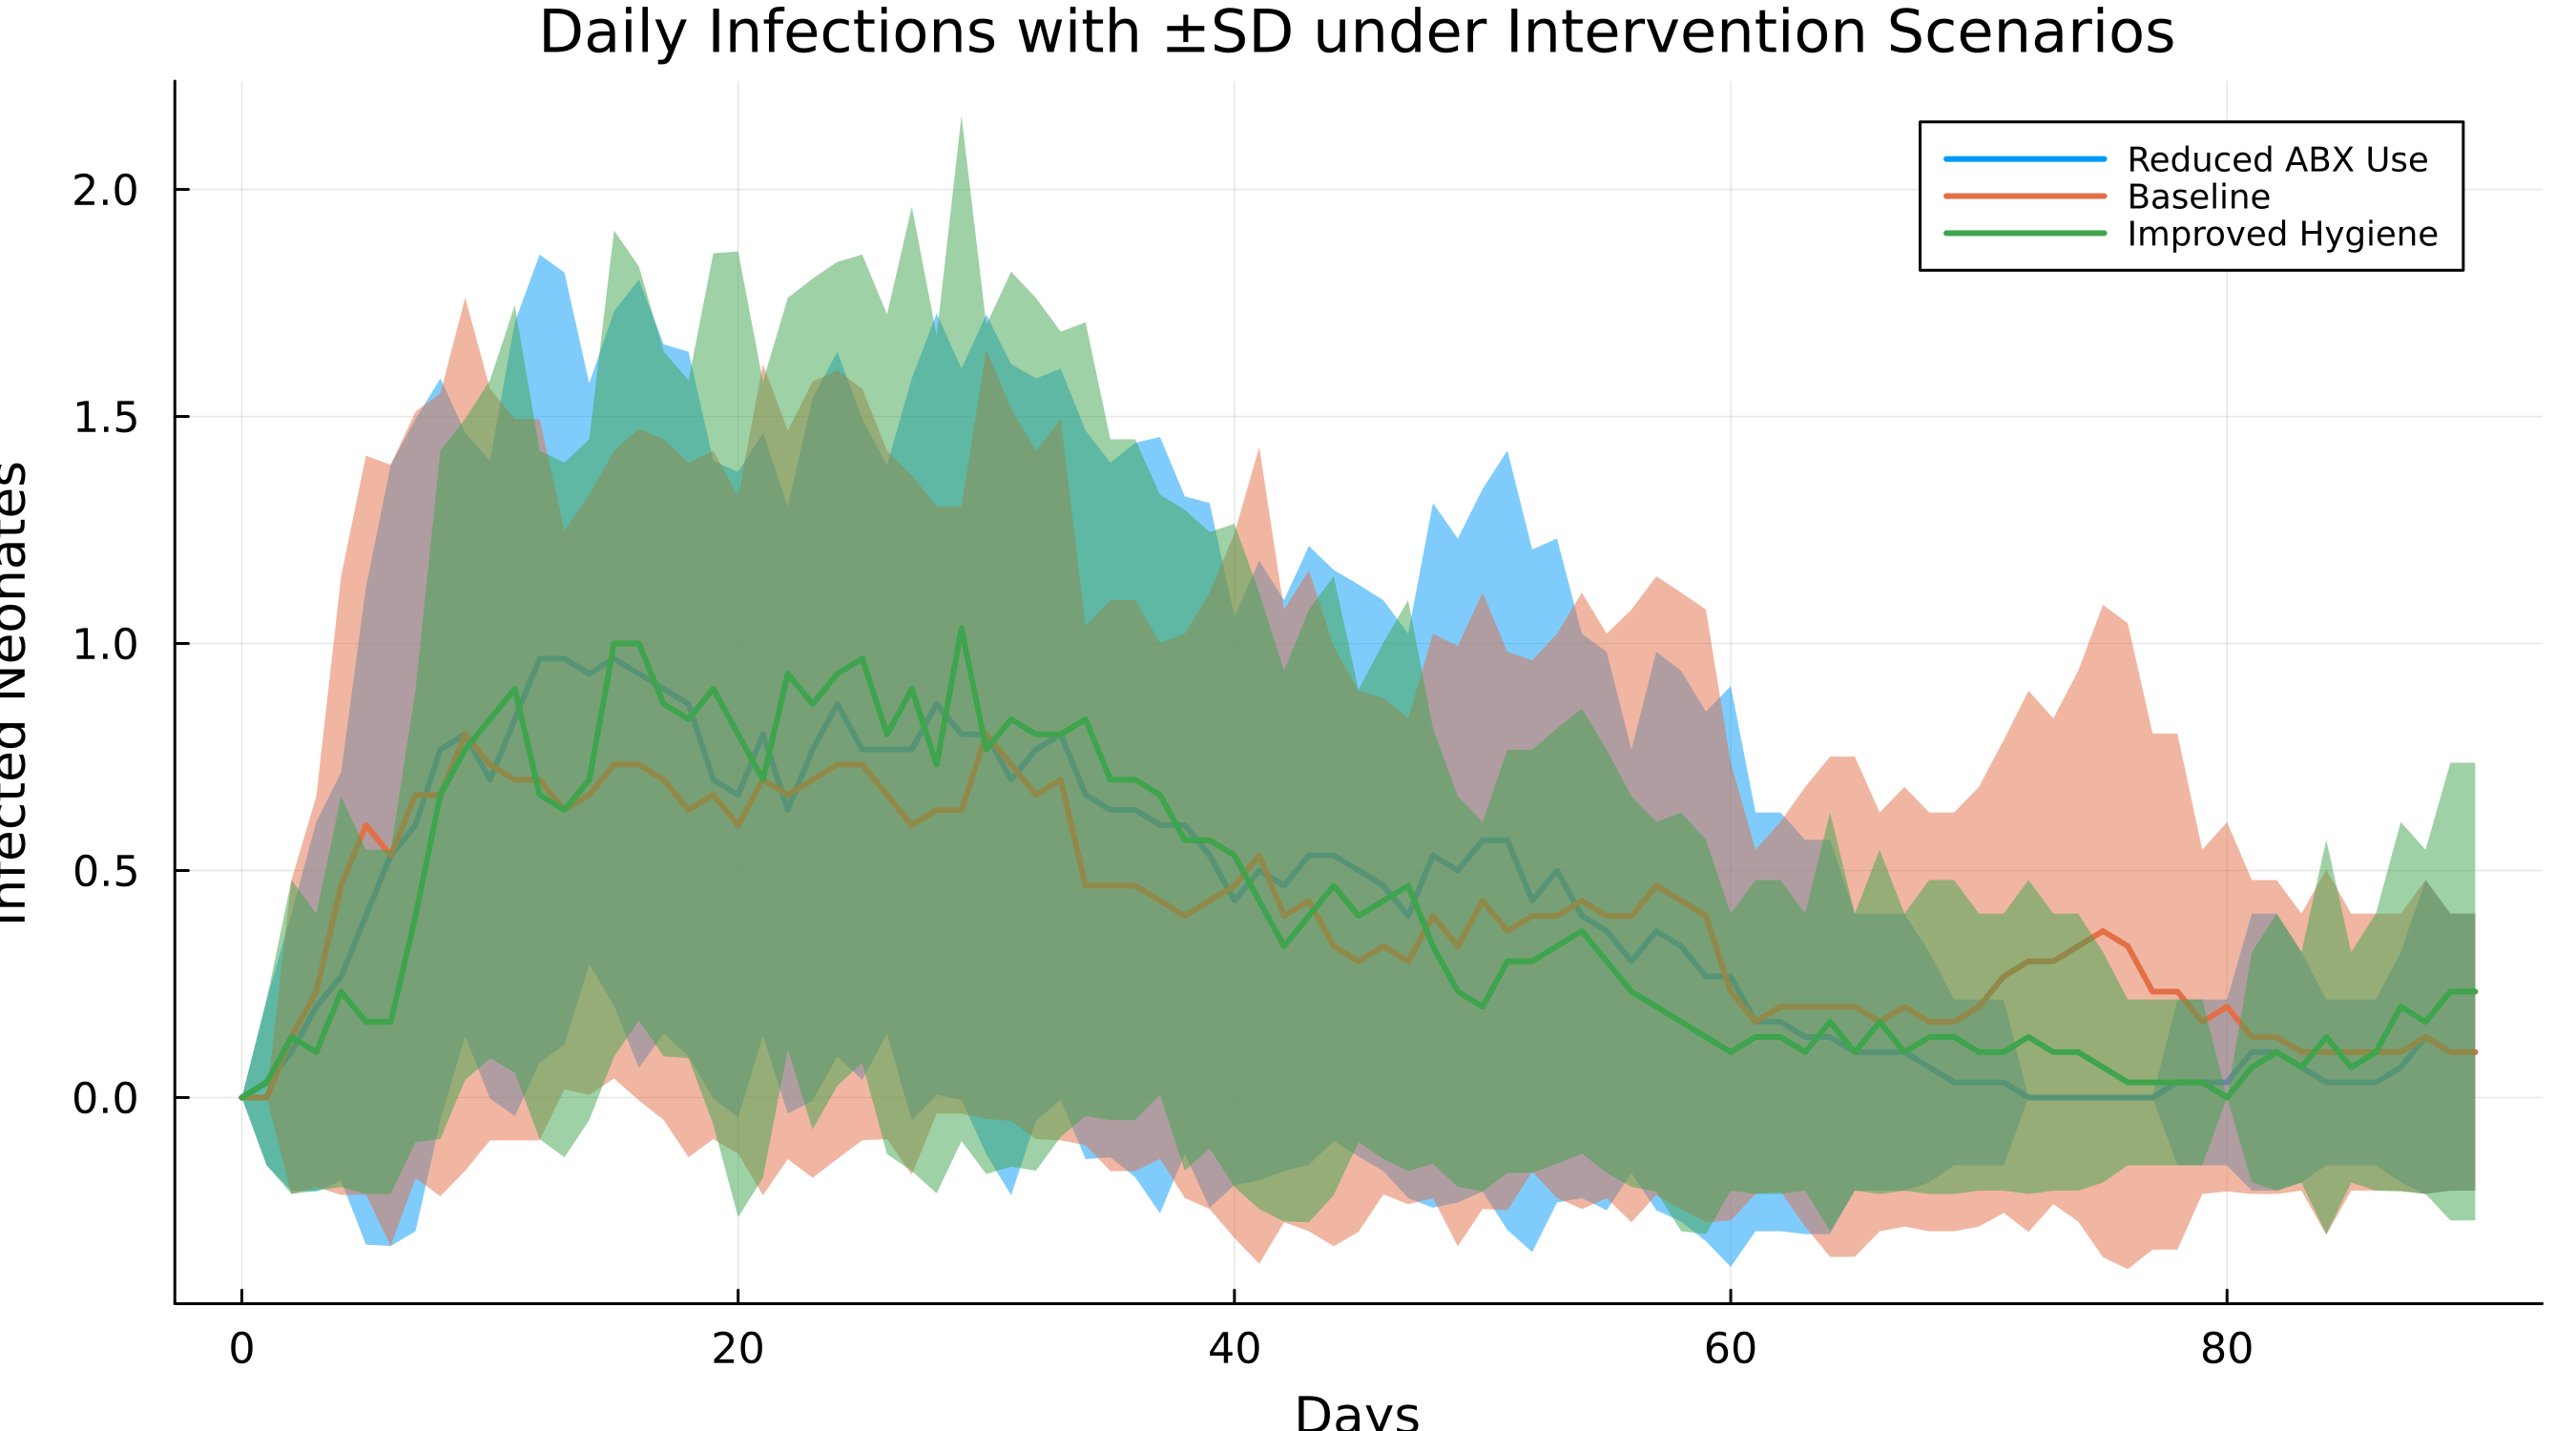

Running scenario: Reduced ABX Use
Running scenario: Baseline
Running scenario: Improved Hygiene

In [73]:
using StatsBase, Statistics, Plots

# 定义干预场景参数
const SCENARIOS = Dict(
    "Baseline" => (; p_decontam_hcw=0.4, abx_course=5),
    "Improved Hygiene" => (; p_decontam_hcw=0.8, abx_course=5),
    "Reduced ABX Use" => (; p_decontam_hcw=0.4, abx_course=2)
)

# 多次模拟，输出平均值 + 标准差
function simulate_scenario_sd(; p_decontam_hcw=0.4, abx_course=5, N_runs=30, days=90)
    all_curves = []

    for _ in 1:N_runs
        env = init_env(p_decontam_hcw=p_decontam_hcw, abx_course=abx_course)
        run!(env, days=days)
        daily_inf = [env.stats[I_S][t] + env.stats[I_R][t] for t in 1:(days+1)]
        push!(all_curves, daily_inf)
    end

    mat = reduce(hcat, all_curves)  # 每列是一条曲线
    mean_inf = mean(mat, dims=2)[:]
    sd_inf = std(mat, dims=2)[:]
    return mean_inf, sd_inf
end

# 执行所有场景模拟
scenario_means = Dict{String,Vector{Float64}}()
scenario_sds = Dict{String,Vector{Float64}}()

for (name, params) in SCENARIOS
    println("Running scenario: $name")
    μ, σ = simulate_scenario_sd(; params...)
    scenario_means[name] = μ
    scenario_sds[name] = σ
end

# 绘图：带 ribbon（±SD）
days = 0:90
plt = plot(title="Daily Infections with ±SD under Intervention Scenarios",
    xlabel="Days", ylabel="Infected Neonates", legend=:topright,
    dpi=300, size=(900, 500),
    xtickfont=font(10), ytickfont=font(10),
    guidefont=font(12), titlefont=font(14), lw=2)

for (label, μ) in scenario_means
    σ = scenario_sds[label]
    plot!(plt, days, μ, ribbon=σ, label=label, lw=2)
end

display(plt)